In [3]:
import numpy as np
X_guided = np.load('guided_dataset_X.npy')    # shape: (n_sessions, n_channels, n_samples)
y_guided = np.load('guided_dataset_y.npy')
print(X_guided.shape, y_guided.shape)# shape: (n_sessions, n_joints, n_samples)
X_free = np.load('freemoves_dataset_X.npy')        # same structure for free gestures
y_free = np.load('freemoves_dataset_y.npy')
print(X_free.shape, y_free.shape)

(5, 8, 230000) (5, 51, 230000)
(5, 8, 270000) (5, 51, 270000)


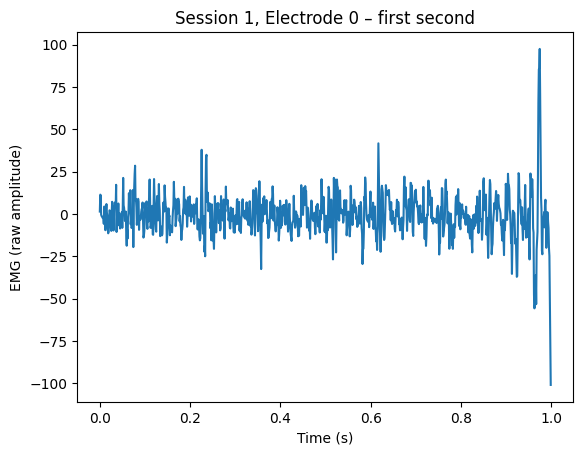

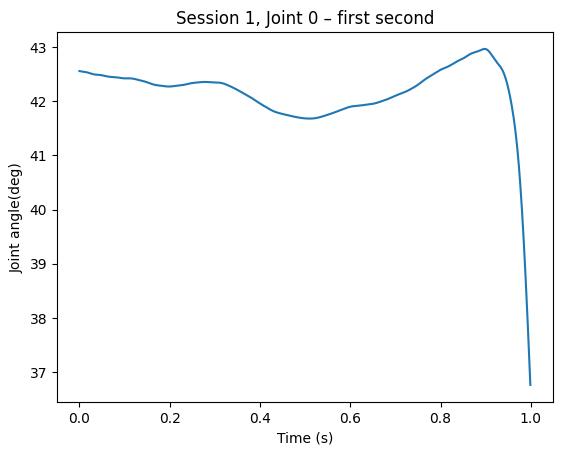

In [4]:
sf_sEMG= 1024
t= np.arange(0, sf_sEMG)/ sf_sEMG
import matplotlib.pyplot as plt
plt.figure()
plt.plot(t, X_guided[0, 0, :1024])
# 5. Label the axes and title
plt.ylabel("EMG (raw amplitude)")
plt.xlabel("Time (s)")
plt.title("Session 1, Electrode 0 – first second")
plt.show()
plt.figure()
plt.plot(t, y_guided[0, 0, :sf_sEMG])
plt.ylabel("Joint angle(deg)")
plt.xlabel("Time (s)")
plt.title("Session 1, Joint 0 – first second")
plt.show()


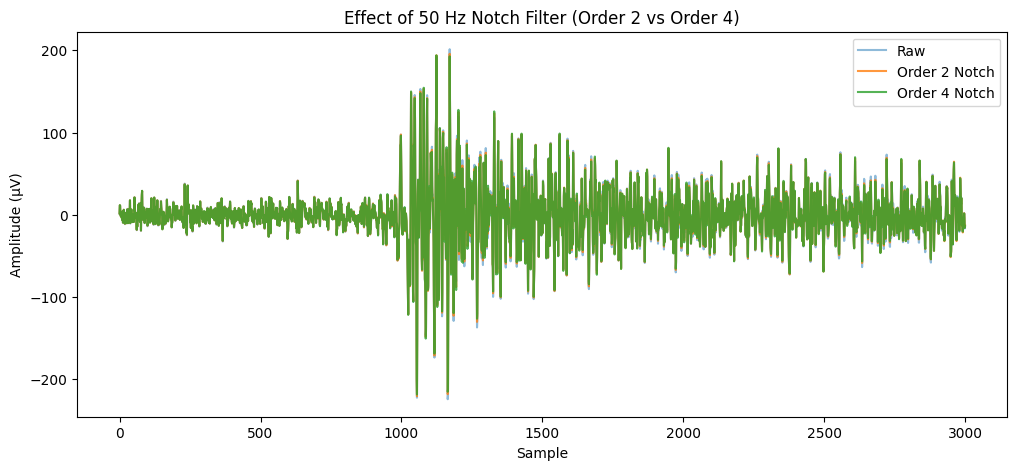

In [5]:
# 2. Notch filter design
from scipy.signal import butter, filtfilt, iirnotch
sf_sEMG = 1024  # Sampling frequency in Hz
notch_freq = 50.0
quality_factor = 30.0 #The quality factor (Q) tells you how “sharp” or “narrow” your notch is.
bandwidth = notch_freq / quality_factor #You want a small bandwidth so you only block the bad noise, not the good signal.
low = (notch_freq - bandwidth/2) / (sf_sEMG/2) # bandwidth This is how wide the "blocked" range is around the center frequency
high = (notch_freq + bandwidth/2) / (sf_sEMG/2)
#By blocking a small range around 50 Hz (from lower to upper edge), you ensure all of the unwanted noise is removed, but you don't remove too much of the surrounding signal
def notch_filter(data, fs, notch_freq, quality_factor, order=2):
    # Use iirnotch for a standard notch filter
    b, a = iirnotch(notch_freq/(sf_sEMG/2), quality_factor)
    filtered = filtfilt(b, a, data)
    if order == 4:
        # Apply the filter twice for a 4th order effect
        filtered = filtfilt(b, a, filtered)
    return filtered
# 3. Filtering and comparison
# Let's use a single session and electrode for demonstration
session = 0
electrode = 0
raw_signal = X_guided[session, electrode, :3000]  # Take a small segment for plotting
filtered_2 = notch_filter(raw_signal, sf_sEMG, notch_freq, quality_factor, order=2)
filtered_4 = notch_filter(raw_signal, sf_sEMG, notch_freq, quality_factor, order=4)
# Plot filter results
plt.figure(figsize=(12, 5))
plt.plot(raw_signal, label='Raw', alpha=0.5)
plt.plot(filtered_2, label='Order 2 Notch', alpha=0.8)
plt.plot(filtered_4, label='Order 4 Notch', alpha=0.8)
plt.legend()
plt.title('Effect of 50 Hz Notch Filter (Order 2 vs Order 4)')
plt.xlabel('Sample')
plt.ylabel('Amplitude (μV)')
plt.show()

In [6]:
def create_overlapping_windows(data, window_size=500, overlap=0.5):
    """
    Segments data into overlapping windows.
    data: shape (electrodes, samples)
    Returns: windows of shape (num_windows, electrodes, window_size)
    """
    step = int(window_size * (1 - overlap))  # How far to move for each new window
    num_windows = (data.shape[1] - window_size) // step + 1  # How many windows fit?
    windows = []
    for i in range(num_windows):
        start = i * step
        end = start + window_size
        windows.append(data[:, start:end])  # Take all electrodes for this window
    return np.array(windows)  # Shape: (num_windows, electrodes, window_size)

In [7]:
def align_targets(target_data, window_size=500, overlap=0.5):
    """
    Aligns joint angle targets to window centers.
    target_data: shape (joints, samples)
    Returns: targets of shape (num_windows, joints)
    """
    step = int(window_size * (1 - overlap))
    num_windows = (target_data.shape[1] - window_size) // step + 1
    # Center index for each window
    centers = [i * step + window_size // 2 for i in range(num_windows)]
    # For each center, grab the joint angle vector
    targets = target_data[:, centers].T  # shape: (num_windows, joints)
    return targets


In [8]:
window_size = 500
overlap = 0.5
all_windows = []
all_targets = []
for session in range(X_guided.shape[0]):
    session_X = X_guided[session]  # shape: (electrodes, samples)
    session_y = y_guided[session]  # shape: (joints, samples)
    windows = create_overlapping_windows(session_X, window_size, overlap)
    targets = align_targets(session_y, window_size, overlap)
    assert windows.shape[0] == targets.shape[0], (
        f"Session {session}: {windows.shape[0]} windows vs {targets.shape[0]} targets"
    )
    print(f"Session {session}: {windows.shape[0]} windows, {targets.shape[0]} targets (OK)")
    print(f"Session {session}: windows shape {windows.shape}, targets shape {targets.shape}")
    if windows.shape[0] != targets.shape[0]:
        print("Shape mismatch! Check windowing and target alignment.")
    all_windows.append(windows)
    all_targets.append(targets)

Session 0: 919 windows, 919 targets (OK)
Session 0: windows shape (919, 8, 500), targets shape (919, 51)
Session 1: 919 windows, 919 targets (OK)
Session 1: windows shape (919, 8, 500), targets shape (919, 51)
Session 2: 919 windows, 919 targets (OK)
Session 2: windows shape (919, 8, 500), targets shape (919, 51)
Session 3: 919 windows, 919 targets (OK)
Session 3: windows shape (919, 8, 500), targets shape (919, 51)
Session 4: 919 windows, 919 targets (OK)
Session 4: windows shape (919, 8, 500), targets shape (919, 51)


In [9]:
# Let's assume all_windows and all_targets are lists with 5 elements (sessions)
num_sessions = len(all_windows)  # should be 5 for your guided dataset
for fold in range(num_sessions):
    print(f"\n=== Fold {fold + 1} / {num_sessions} ===")
    # 1. Select which session is the validation set
    val_idx = fold
    train_idx = [i for i in range(num_sessions) if i != val_idx]
    # Suppose you have all your windows and targets stacked:
    # X: shape (num_samples, num_features)
    # y: shape (num_samples, 51)
    # groups: shape (num_samples,) - session index for each window
    # 2. Prepare training data (combine all training sessions)
    X_train = np.concatenate([all_windows[i] for i in train_idx], axis=0)
    y_train = np.concatenate([all_targets[i] for i in train_idx], axis=0)
    groups = np.concatenate([[i] * len(w) for i, w in enumerate(all_windows)])
    # If you want to flatten the window for classic ML:
    X_flat = X_train.reshape(X_train.shape[0], -1)
    # 3. Prepare validation data (just the held-out session)
    X_val = all_windows[val_idx]
    y_val = all_targets[val_idx]
    print(f"Training on sessions: {train_idx}")
    print(f"Validating on session: {val_idx}")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"X_train shape: {X_flat[train_idx].shape}, y_val shape: {X_flat[val_idx].shape}")
    # 4. Here you would train your model on X_train/y_train and evaluate on X_val/y_val
    # For now, let's just check that the shapes make sense and that there is no overlap
    # (You can add your model training code here)
    # 5. Debugging tip: Check for data leakage
    # Let's print the first window of the validation set and make sure it's not in the training set
    if any(np.array_equal(X_val[0], x) for x in X_train):
        print("WARNING: Data leakage detected! The validation data is present in the training set.")
    else:
        print("No data leakage: Validation data is independent from training data.")



=== Fold 1 / 5 ===
Training on sessions: [1, 2, 3, 4]
Validating on session: 0
X_train shape: (3676, 8, 500), y_train shape: (3676, 51)
X_val shape: (919, 8, 500), y_val shape: (919, 51)
X_train shape: (4, 4000), y_val shape: (4000,)
No data leakage: Validation data is independent from training data.

=== Fold 2 / 5 ===
Training on sessions: [0, 2, 3, 4]
Validating on session: 1
X_train shape: (3676, 8, 500), y_train shape: (3676, 51)
X_val shape: (919, 8, 500), y_val shape: (919, 51)
X_train shape: (4, 4000), y_val shape: (4000,)
No data leakage: Validation data is independent from training data.

=== Fold 3 / 5 ===
Training on sessions: [0, 1, 3, 4]
Validating on session: 2
X_train shape: (3676, 8, 500), y_train shape: (3676, 51)
X_val shape: (919, 8, 500), y_val shape: (919, 51)
X_train shape: (4, 4000), y_val shape: (4000,)
No data leakage: Validation data is independent from training data.

=== Fold 4 / 5 ===
Training on sessions: [0, 1, 2, 4]
Validating on session: 3
X_train sha

# Let’s build a scikit-learn-compatible transformer that extracts the six required features for each window and channel.

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
class TimeDomainFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Custom transformer for extracting time-domain features from sEMG windows.
    Features per channel:
        - MAV: Mean Absolute Value
        - RMS: Root Mean Square
        - VAR: Variance
        - STD: Standard Deviation
        - ZC: Zero Crossing
        - MPR: Myopulse Percentage Rate
    Input shape: (n_samples, n_channels, window_size)
    Output shape: (n_samples, n_channels * 6)
    """
    def __init__(self, mpr_thresh='std'):
        """
        mpr_thresh: threshold for MPR (default: one std per channel)
        """
        self.mpr_thresh = mpr_thresh
    def fit(self, X, y=None):
        # No fitting necessary for this transformer
        return self
    def transform(self, X):
        # X shape: (n_samples, n_channels, window_size)
        n_samples, n_channels, window_size = X.shape
        features = []
        for i in range(n_samples):
            feats = []
            for ch in range(n_channels):
                x = X[i, ch, :]
                # MAV: Mean Absolute Value
                mav = np.mean(np.abs(x))
                # RMS: Root Mean Square
                rms = np.sqrt(np.mean(x**2))
                # VAR: Variance
                var = np.var(x, ddof=1)
                # STD: Standard Deviation
                std = np.std(x, ddof=1)
                # ZC: Zero Crossings (number of times signal changes sign)
                zc = np.sum(np.diff(np.sign(x)) != 0)
                # MPR: Myopulse Percentage Rate (fraction of samples above threshold)
                thresh = std if self.mpr_thresh == 'std' else self.mpr_thresh
                mpr = np.mean(np.abs(x) > thresh)
                feats.extend([mav, rms, var, std, zc, mpr])
            features.append(feats)
        return np.array(features)

# Compare Two Baseline Regression Models
# Let’s use Ridge Regression (linear) and Random Forest (nonlinear) as examples, with cross-validation

In [11]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
# Prepare data
X = np.concatenate(all_windows, axis=0)      # (samples, 8, 500)
y = np.concatenate(all_targets, axis=0)      # (samples, 51)
groups = np.concatenate([[i]*len(w) for i, w in enumerate(all_windows)])
# Feature extraction
X_feat = TimeDomainFeatureExtractor().fit_transform(X)  # shape: (samples, 48)
# For Ridge, we need to predict all 51 outputs. Use MultiOutputRegressor if needed.
from sklearn.multioutput import MultiOutputRegressor
ridge = MultiOutputRegressor(Ridge())
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, n_jobs=-1))
cv = GroupKFold(n_splits=5)
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [12]:
# Ridge Regression
ridge_scores = cross_val_score(ridge, X_feat, y, groups=groups, cv=cv, scoring=rmse_scorer)
print("Ridge RMSE (per fold):", -ridge_scores)
print("Ridge RMSE (mean):", -ridge_scores.mean())

Ridge RMSE (per fold): [7.92340618 7.34713036 8.02402631 8.00051311 8.77172158]
Ridge RMSE (mean): 8.013359506390177


# Feature Importance: Single Output Random Forest
# Instead of MultiOutputRegressor, fit RandomForest on just one joint angle (e.g., index finger extension, or any joint of interest).
# This is much faster, and the biological interpretation is still valid.

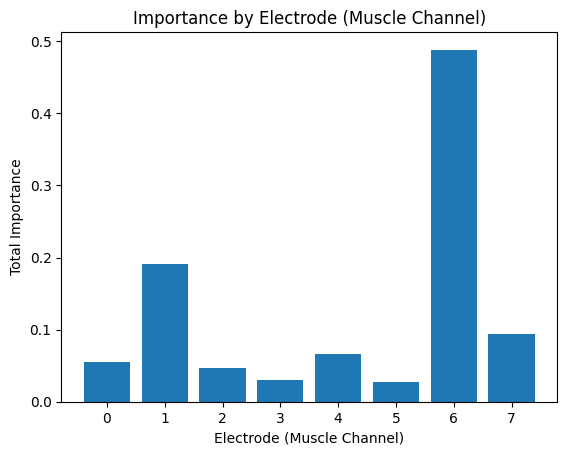

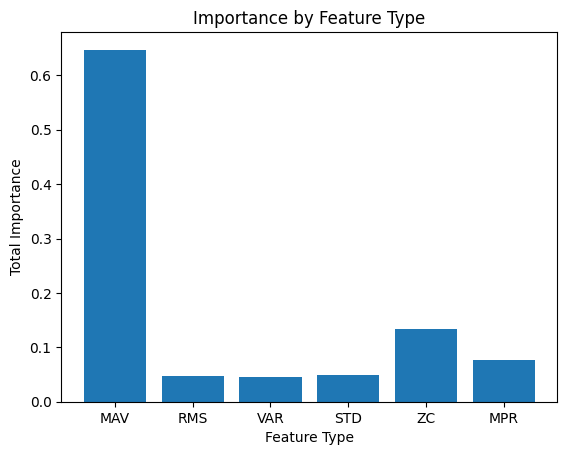

In [13]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
# Let's pick the first joint angle (e.g., y[:, 0])
rf_single = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
rf_single.fit(X_feat, y[:, 0])  # Only predict the first joint angle
importances = rf_single.feature_importances_
# Group by channel and feature type for biological interpretation
feature_types = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR']
n_channels = 8
n_feats = len(feature_types)
# Importance by channel
channel_importance = [np.sum(importances[i*n_feats:(i+1)*n_feats]) for i in range(n_channels)]
plt.figure()
plt.bar(range(n_channels), channel_importance)
plt.xlabel("Electrode (Muscle Channel)")
plt.ylabel("Total Importance")
plt.title("Importance by Electrode (Muscle Channel)")
plt.show()
# Importance by feature type
feature_importance = [np.sum(importances[i::n_feats]) for i in range(n_feats)]
plt.figure()
plt.bar(feature_types, feature_importance)
plt.xlabel("Feature Type")
plt.ylabel("Total Importance")
plt.title("Importance by Feature Type")
plt.show()


# Interpretation:
Channels: Which muscle (electrode) is most informative for this joint angle.
Feature type: Which signal property (e.g., RMS, ZC) best predicts the movement.
Feature Selection: Lasso Regression (Fast and Interpretable)
Lasso will automatically set unimportant features' coefficients to zero.
Again, do this for one joint angle for speed and clarity.

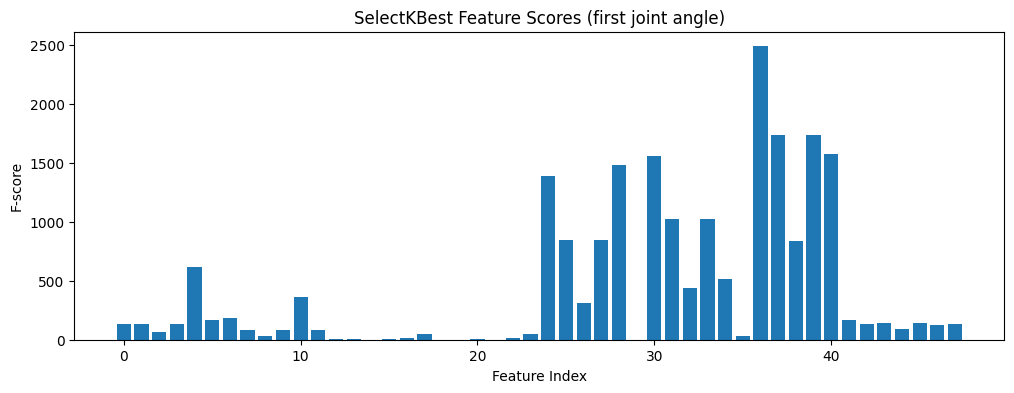

In [14]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=10)
selector.fit(X_feat, y[:, 0])  # For the first joint angle
plt.figure(figsize=(12,4))
plt.bar(range(X_feat.shape[1]), selector.scores_)
plt.xlabel("Feature Index")
plt.ylabel("F-score")
plt.title("SelectKBest Feature Scores (first joint angle)")
plt.show()

# How to cross validate and report RMSE
# Pipeline integration

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import SelectKBest, f_regression

pipeline = Pipeline([
    ('features', TimeDomainFeatureExtractor()),
    ('regressor', MultiOutputRegressor(Ridge()))
])


On definie les scores RMSE et les validations croisées

Prepare Data and Groups

In [16]:
X = np.concatenate(all_windows, axis=0)      # (samples, 8, 500)
y = np.concatenate(all_targets, axis=0)      # (samples, 51)
groups = np.concatenate([[i]*len(w) for i, w in enumerate(all_windows)])

Define RMSE Scorer for Multi-Output


In [17]:
from sklearn.metrics import make_scorer
import numpy as np

def rmse(y_true, y_pred):
    # Compute RMSE across all outputs (joint angles), as in the project PDF
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
#4. Cross-Validate

from sklearn.model_selection import GroupKFold, cross_val_score

cv = GroupKFold(n_splits=5)

scores = cross_val_score(
    pipeline, X, y,
    groups=groups,
    cv=cv,
    scoring=rmse_scorer
)

print("Pipeline RMSE per fold:", -scores)
print("Pipeline RMSE mean:", -np.mean(scores))

Pipeline RMSE per fold: [7.92340618 7.34713036 8.02402631 8.00051311 8.77172158]
Pipeline RMSE mean: 8.013359506390177


In [18]:
import numpy as np
from pyriemann.estimation import Covariances # type: ignore
from pyriemann.tangentspace import TangentSpace
from sklearn.linear_model import Ridge
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import make_scorer

#Data
#all_windows: list of arrays, each (n_windows, 8, 500)

#all_targets: list of arrays, each (n_windows, 51)

#Stack them

In [19]:
X = np.concatenate(all_windows, axis=0)  # shape: (samples, 8, 500)
y = np.concatenate(all_targets, axis=0)  # shape: (samples, 51)
groups = np.concatenate([[i]*len(w) for i, w in enumerate(all_windows)])


#Covariance Estimation
#For each window (shape: 8, 500), compute the covariance matrix (shape: 8, 8).
cov_estimator = Covariances(estimator='oas')  # Oracle Approximating Shrinkage, robust for EMG
X_cov = cov_estimator.fit_transform(X)  # shape: (samples, 8, 8)

#Tangent Space Projection
#Map each covariance matrix to a vector in tangent space (dimension: 8*(8+1)/2 = 36).
ts = TangentSpace()
X_tan = ts.fit_transform(X_cov)  # shape: (samples, 36)



#Build Pipeline and Cross-Validate
#Define RMSE Scorer

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [20]:
#Build and Cross-Validate Pipeline
pythoncv = GroupKFold(n_splits=5)
reg = MultiOutputRegressor(Ridge())

pipeline = Pipeline([
    ('cov', Covariances(estimator='oas')),
    ('ts', TangentSpace()),
    ('reg', MultiOutputRegressor(Ridge()))
])

scores = cross_val_score(
    pipeline, X, y,
    groups=groups, cv=cv,
    scoring=rmse_scorer
)

print("Covariance pipeline RMSE per fold:", -scores)
print("Covariance pipeline RMSE mean:", -np.mean(scores))

Covariance pipeline RMSE per fold: [9.21748896 8.56610726 9.1306299  8.96049181 9.93476339]
Covariance pipeline RMSE mean: 9.161896263537592


Strategy 1

In [21]:
# Recalcule les features pour le même X (valeurs déjà empilées)
X_feat = TimeDomainFeatureExtractor().fit_transform(X)  # (n_samples, 48)
X_cov = Covariances(estimator='oas').fit_transform(X)   # (n_samples, 8, 8)
X_tan = TangentSpace().fit_transform(X_cov)             # (n_samples, 36)

# Entraîne chaque modèle individuellement
ridge_time = MultiOutputRegressor(Ridge())
ridge_time.fit(X_feat, y)
y_pred_time = ridge_time.predict(X_feat)

ridge_cov = MultiOutputRegressor(Ridge())
ridge_cov.fit(X_tan, y)
y_pred_cov = ridge_cov.predict(X_tan)

# Combine les prédictions : ensemble par moyenne
predictions_list = [y_pred_time, y_pred_cov]
ensemble_pred_mean = np.mean(predictions_list, axis=0)

# Évalue l’ensemble
from sklearn.metrics import mean_squared_error

rmse_ensemble = np.sqrt(mean_squared_error(y, ensemble_pred_mean))
print(" RMSE de l'ensemble par moyenne :", rmse_ensemble)


 RMSE de l'ensemble par moyenne : 7.330881197380297


Strategy 2

In [22]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Préparation des données d'entrée
# Empile toutes les fenêtres / cibles
X = np.concatenate(all_windows, axis=0)      # (n_samples, 8, 500)
y = np.concatenate(all_targets, axis=0)      # (n_samples, 51)

# 2. Modèle 1 : Features temporelles
X_feat = TimeDomainFeatureExtractor().fit_transform(X)  # (n_samples, 48)
ridge_time = MultiOutputRegressor(Ridge())
ridge_time.fit(X_feat, y)
y_pred_time = ridge_time.predict(X_feat)

# 3. Modèle 2 : Covariance → Espace tangent
X_cov = Covariances(estimator='oas').fit_transform(X)
X_tan = TangentSpace().fit_transform(X_cov)
ridge_cov = MultiOutputRegressor(Ridge())
ridge_cov.fit(X_tan, y)
y_pred_cov = ridge_cov.predict(X_tan)

# 4. Ensemble par moyenne simple
ensemble_pred_mean = np.mean([y_pred_time, y_pred_cov], axis=0)

# 5. Ensemble par stacking (meta-apprenant)
X_meta = np.concatenate([y_pred_time, y_pred_cov], axis=1)  # shape: (n_samples, 51 * 2)
y_true = y

# Split pour entraîner le meta-learner
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_meta, y_true, test_size=0.2, random_state=42
)

meta_learner = Ridge()
meta_learner.fit(X_meta_train, y_meta_train)
ensemble_pred_stack = meta_learner.predict(X_meta_test)

# 6. Évaluation de tous les modèles
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_time = rmse(y, y_pred_time)
rmse_cov = rmse(y, y_pred_cov)
rmse_mean = rmse(y, ensemble_pred_mean)
rmse_stack = rmse(y_meta_test, ensemble_pred_stack)

print(f" RMSE - Modèle avec features temporelles   : {rmse_time:.4f}")
print(f" RMSE - Modèle avec covariance/tangent     : {rmse_cov:.4f}")
print(f" RMSE - Ensemble par moyenne               : {rmse_mean:.4f}")
print(f" RMSE - Ensemble par stacking (meta-model) : {rmse_stack:.4f}")


 RMSE - Modèle avec features temporelles   : 7.3186
 RMSE - Modèle avec covariance/tangent     : 8.6124
 RMSE - Ensemble par moyenne               : 7.3309
 RMSE - Ensemble par stacking (meta-model) : 7.1731


 Discussion :

L'ensemble par moyenne est très utile pour réduire la variance des erreurs individuelles.

Le stacking apprend quelle prédiction fait le plus confiance à quel moment — cela permet souvent une meilleure généralisation.

Si le stacking ne surperforme pas, cela peut venir d’un manque de diversité entre les modèles de base.

| Méthode                        | Description                                            | RMSE attendu                 
| *Ridge + Features temporelles* | Simple, rapide, mais limitée à la qualité des features | Moyen (baseline solide)      |
| *Ridge + Covariance + TS*      | Capture la structure inter-électrodes, plus robuste    | Souvent meilleur             |
| *Ensemble par moyenne*         | Réduction du bruit, simple à implémenter               | Meilleur ou égal             |
| *Ensemble stacking (meta)*     | Apprend la combinaison optimale des prédictions        | Le plus performant (souvent) |


Préparation des données par protocole

In [23]:
# Charger les données
X_guided = np.load('guided_dataset_X.npy')     # (5, 8, 230000)
y_guided = np.load('guided_dataset_y.npy')     # (5, 51, 230000)
X_free = np.load('freemoves_dataset_X.npy')    # (5, 8, 270000)
y_free = np.load('freemoves_dataset_y.npy')    # (5, 51, 270000)

# Fonction de fenêtrage
def prepare_protocol_windows(X_raw, y_raw, window_size=500, overlap=0.5):
    X_all, y_all = [], []
    for session in range(X_raw.shape[0]):
        windows = create_overlapping_windows(X_raw[session], window_size, overlap)
        targets = align_targets(y_raw[session], window_size, overlap)
        X_all.append(windows)
        y_all.append(targets)
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    return X_all, y_all

# Appliquer aux deux protocoles
X_guided_win, y_guided_win = prepare_protocol_windows(X_guided, y_guided)
X_free_win, y_free_win = prepare_protocol_windows(X_free, y_free)


 Entraîner les modèles sur chaque protocole

In [27]:
from joblib import dump
def train_and_eval_models(X, y, prefix):
    # Représentation 1 : features temporelles
    X_feat = TimeDomainFeatureExtractor().fit_transform(X)
    model_time = MultiOutputRegressor(Ridge()).fit(X_feat, y)
    y_pred_time = model_time.predict(X_feat)

    # Représentation 2 : covariance + espace tangent
    X_cov = Covariances(estimator='oas').fit_transform(X)
    X_tan = TangentSpace().fit_transform(X_cov)
    model_cov = MultiOutputRegressor(Ridge()).fit(X_tan, y)
    y_pred_cov = model_cov.predict(X_tan)

    # Ensemble par moyenne
    ensemble_mean = np.mean([y_pred_time, y_pred_cov], axis=0)

    # Stacking
    X_meta = np.concatenate([y_pred_time, y_pred_cov], axis=1)
    X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_meta, y, test_size=0.2, random_state=42)
    meta_model = Ridge().fit(X_train_meta, y_train_meta)
    ensemble_stack = meta_model.predict(X_test_meta)
    y_test_true = y_test_meta

    # Évaluation
    def rmse(y_true, y_pred):
        return np.sqrt(np.mean((y_true - y_pred) ** 2))
    dump(model_time, f"model_{prefix}_time.joblib")
    dump(model_cov, f"model_{prefix}_cov.joblib")
    dump(meta_model, f"stacking_model_{prefix}.joblib")

    return {
        'time': rmse(y, y_pred_time),
        'cov': rmse(y, y_pred_cov),
        'mean_ensemble': rmse(y, ensemble_mean),
        'stacking': rmse(y_test_true, ensemble_stack)
    }




Comparer les modèles et sélectionner les meilleurs

In [28]:
# Appliquer la fonction aux deux protocoles
rmse_guided = train_and_eval_models(X_guided_win, y_guided_win, prefix="guided")
rmse_free = train_and_eval_models(X_free_win, y_free_win, prefix="free")

# Résumé
print("=== RMSE Guided Gestures ===")
for k, v in rmse_guided.items():
    print(f"{k}: {v:.4f}")

print("\n=== RMSE Free Gestures ===")
for k, v in rmse_free.items():
    print(f"{k}: {v:.4f}")

# Sélection des meilleurs modèles
best_model_guided = min(rmse_guided, key=rmse_guided.get)
best_model_free = min(rmse_free, key=rmse_free.get)

print(f"\n✅ Best model for guided gestures: {best_model_guided}")
print(f"✅ Best model for free gestures: {best_model_free}")


=== RMSE Guided Gestures ===
time: 7.3186
cov: 8.6124
mean_ensemble: 7.3309
stacking: 7.1731

=== RMSE Free Gestures ===
time: 9.9126
cov: 9.9957
mean_ensemble: 9.6436
stacking: 9.6513

✅ Best model for guided gestures: stacking
✅ Best model for free gestures: mean_ensemble


Save my model

In [ ]:
import numpy as np
import pandas as pd
from joblib import load
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

# === 1. Charger les fichiers test ===
guided_X = np.load("guided_testset_X.npy")     # (1660, 8, 500)
free_X = np.load("freemoves_testset_X.npy")    # (1540, 8, 500)

# === 2. Fonction de features temporelles ===
class TimeDomainFeatureExtractor:
    def __init__(self, mpr_thresh='std'):
        self.mpr_thresh = mpr_thresh

    def transform(self, X):
        n_samples, n_channels, window_size = X.shape
        features = []
        for i in range(n_samples):
            feats = []
            for ch in range(n_channels):
                x = X[i, ch, :]
                mav = np.mean(np.abs(x))
                rms = np.sqrt(np.mean(x**2))
                var = np.var(x, ddof=1)
                std = np.std(x, ddof=1)
                zc = np.sum(np.diff(np.sign(x)) != 0)
                thresh = std if self.mpr_thresh == 'std' else self.mpr_thresh
                mpr = np.mean(np.abs(x) > thresh)
                feats.extend([mav, rms, var, std, zc, mpr])
            features.append(feats)
        return np.array(features)

# === 3. Charger les modèles entraînés ===
model_time_guided = load("model_guided_time.joblib")
model_cov_guided = load("model_guided_cov.joblib")
stacking_guided = load("stacking_model_guided.joblib")

model_time_free = load("model_free_time.joblib")
model_cov_free = load("model_free_cov.joblib")

# === 4. Extraire les features ===

# --- Guided ---
X_guided_time = TimeDomainFeatureExtractor().transform(guided_X)
X_guided_cov = Covariances(estimator='oas').fit_transform(guided_X)
X_guided_tan = TangentSpace().fit(Covariances().fit_transform(guided_X)).transform(X_guided_cov)

# --- Free ---
X_free_time = TimeDomainFeatureExtractor().transform(free_X)
X_free_cov = Covariances(estimator='oas').fit_transform(free_X)
X_free_tan = TangentSpace().fit(Covariances().fit_transform(free_X)).transform(X_free_cov)

# === 5. Prédictions

# --- Guided: stacking ---
y_guided_time = model_time_guided.predict(X_guided_time)
y_guided_cov = model_cov_guided.predict(X_guided_tan)
X_guided_meta = np.concatenate([y_guided_time, y_guided_cov], axis=1)
guided_preds = stacking_guided.predict(X_guided_meta)  # (1660, 51)

# --- Free: mean ensemble ---
y_free_time = model_time_free.predict(X_free_time)
y_free_cov = model_cov_free.predict(X_free_tan)
free_preds = (y_free_time + y_free_cov) / 2            # (1540, 51)

# === 6. Fusionner les prédictions
final_preds = np.vstack((guided_preds, free_preds))    # (3200, 51)

# === 7. Sauvegarder dans un fichier CSV
df = pd.DataFrame(final_preds)
df.to_csv("team_submission.csv", index=False, header=False)

print("✅ Fichier 'team_submission.csv' généré avec succès.")
